In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data


### organize the data

In [2]:
# ### assemble all socd data points, old and new
# new = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_new.points_overlayed.csv',low_memory=False)
# new.loc[new['ocd']<0, 'ocd'] = 0
# new['ocd_log1p'] = np.log1p(new['ocd'])
# cal = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/ocd/benchmark_cal.pnts_ocd.csv',low_memory=False)
# train = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_train.csv',low_memory=False)
# test = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd_test.csv',low_memory=False)

# socd_newpnts_whole = pd.concat([train, test, new, cal])
# train_cal = pd.concat([train, new, cal])

# # data availability visualization
# a = socd_newpnts_whole[['id', 'lat', 'lon', 'hzn_dep', 'time', 'ref', 'nuts0', 'oc', 'oc_qa', 'ocd', 'ocd_qa']]
# a.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_availibility_socd.new.pnts.csv', index=False)

# # ## split train and calibration data
# cal_new = train_cal.groupby('tile_id', group_keys=False).apply(lambda x: x.sample(frac=0.1))
# train_new = train_cal.drop(cal_new.index)
# cal_new.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data.new.pnts_ocd_cal.csv', index=False)
# train_new.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data.new.pnts_ocd_train.csv', index=False)

In [3]:
train = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data.new.pnts_ocd_train.csv',low_memory=False)
cal = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data.new.pnts_ocd_cal.csv',low_memory=False)

### run the pipeline in modules

In [4]:
# df = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/data/002.2_data_whole.csv', low_memory=False)

start bootstrap on different subset...
[14:06:09] 0 iteration, training size: 1753
[14:06:11] 1 iteration, training size: 1518
[14:06:14] 2 iteration, training size: 1738
[14:06:16] 3 iteration, training size: 1608
[14:06:18] 4 iteration, training size: 1741
[14:06:20] 5 iteration, training size: 1834
[14:06:23] 6 iteration, training size: 1591
[14:06:25] 7 iteration, training size: 1612
[14:06:27] 8 iteration, training size: 1610
[14:06:29] 9 iteration, training size: 1627
[14:06:31] 10 iteration, training size: 1653
[14:06:33] 11 iteration, training size: 1598
[14:06:35] 12 iteration, training size: 1584
[14:06:38] 13 iteration, training size: 1605
[14:06:40] 14 iteration, training size: 1712
[14:06:42] 15 iteration, training size: 1634
[14:06:44] 16 iteration, training size: 1634
[14:06:46] 17 iteration, training size: 1672
[14:06:48] 18 iteration, training size: 1629
[14:06:50] 19 iteration, training size: 1794
start feature elimination evaluation...
[14:06:53] processing 0.0 ...
[

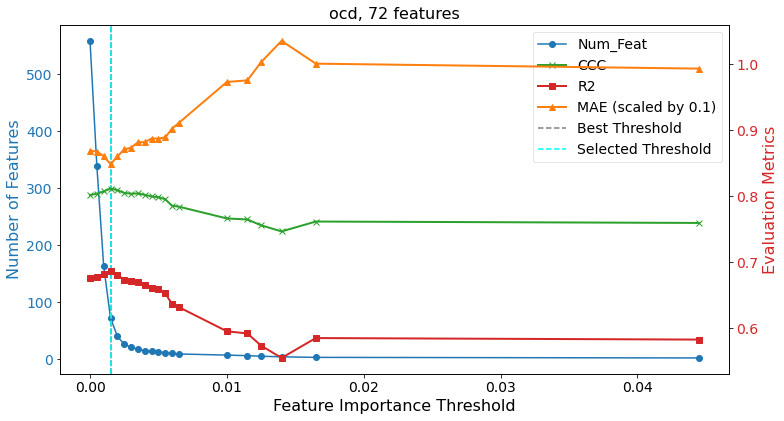

rscfi used 1.4382666269938151 mins


In [5]:
import warnings
warnings.filterwarnings('ignore')
import os
from benchmark_pipeline import run_benchmark
from scipy.stats import boxcox
from scipy.special import inv_boxcox

space = 'log1p'
prop = 'ocd'

output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/new_points'
os.makedirs(output_folder, exist_ok=True)


if space=='log1p':
    # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
    tgt = f'{prop}_log1p'
elif space=='boxcox':
    # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
    tgt = f'{prop}_boxcox'
else:
    tgt = prop
    
    print(f'processing {tgt}')

# features
start = time.time()
covs = run_cumusort(cal, tgt, prop, space, output_folder, threshold_step=0.0005) #, weights_feature=None, threshold_step=0.001
end = time.time()
time_used = (end-start)/60
print(f'rscfi used {time_used} mins')


In [ ]:
    covs = read_features(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt')
    
    # parameter fine-tuning
    models, model_names = parameter_fine_tuning(cal, covs, tgt, prop, output_folder)
    n_trees = len(models[0].estimators_)
    print(f'{tgt}, {n_trees} trees')
    
#     # models
#     model_list = find_files(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/','*model*joblib')
#     model_list = [str(i) for i in model_list]
#     model_names = []
#     models = []
#     for iii in range(len(model_list)):
#         models.append(joblib.load(model_list[iii]))
#         model_names.append(model_list[iii].split('/')[-1][6:-7])
    
#     # # print(model_names)
#     # train = pd.read_csv(f'{output_folder}/benchmark_train.pnts_{prop}.csv',low_memory=False)
#     # test = pd.read_csv(f'{output_folder}/benchmark_test.pnts_{prop}.csv',low_memory=False)
#     evaluate_model(models,model_names,cal,covs,prop,space,output_folder,test=None)
    
# #     # # run the pipeline like a whole
# #     # run_benchmark(folder=folder,
# #     #               output_folder=output_folder,
# #     #               space=space_list[ii],
# #     #               prop=prop,
# #     #               filt=filt_list[ii])
    print('---------------------------------------------------------')

### check

In [5]:
for prop in prop_list:
    covsl = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt'
    # covariates
    covs = read_features(covsl)
    if 'hzn_dep' in covs:
        iss = 'is'
    else:
        iss = 'is not'
    print(f'feature number of {prop}:', len(covs), f', hzn_dep {iss} in the covariates list')

feature number of ocd: 55 , hzn_dep is in the covariates list
feature number of oc: 62 , hzn_dep is in the covariates list
feature number of bulk_density: 59 , hzn_dep is in the covariates list
feature number of ph_cacl2: 56 , hzn_dep is in the covariates list
feature number of ph_h2o: 61 , hzn_dep is in the covariates list
feature number of N: 65 , hzn_dep is in the covariates list
feature number of caco3: 55 , hzn_dep is in the covariates list
feature number of K: 56 , hzn_dep is in the covariates list
feature number of EC: 74 , hzn_dep is in the covariates list
feature number of P: 54 , hzn_dep is in the covariates list
feature number of CEC: 84 , hzn_dep is in the covariates list
feature number of texture1: 34 , hzn_dep is in the covariates list
feature number of texture2: 81 , hzn_dep is in the covariates list


In [8]:
# check all the features used
ll = find_files('/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/production_model/','*.txt')
ll = [str(i) for i in ll if 'checkpoint' not in str(i)]
ln = []
for ii in ll:
    ln.extend(read_features(ii))
    
ln = list(set(ln))
litho = [ii for ii in ln if 'lithology' in ii]

print(f'in total, we used {len(ln)} covariates')

litho


in total, we used 261 covariates


['lithology.94.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
 'lithology.61.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
 'lithology.103.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
 'lithology.57.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
 'lithology.23.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
 'lithology.28.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
 'lithology.46.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
 'lithology.78.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif',
 'lithology.82.lithology_egdi.1m_c_250m_s_20000101_20221231_eu_epsg.3035_v20240530.tif']

### production model

In [10]:
import shutil
n_jobs=90
for ii in range(len(prop_list)):
    space = space_list[ii]
    
    # target property
    prop = prop_list[ii]
    if space=='log1p':
        df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    else:
        tgt = prop
        
    output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}'
    
    # model
    pathm = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/model_rf.{prop}_ccc.joblib'
    model = joblib.load(pathm)
    # model.estimators_ = 64
    n_trees = len(model.estimators_)
    print(f'{tgt}, {n_trees} trees')
    
    # covariates
    pathc = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt'
    covs = read_features(pathc)  
        
    namef = 'propduction.' + pathm.split('/')[-1]
    # update model's n_jobs
    if hasattr(model, 'steps'):  # Check if it's a Pipeline
        for name, estimator in model.steps:
            if hasattr(estimator, 'n_jobs'):
                estimator.n_jobs = n_jobs
                print(f"Updated n_jobs to {n_jobs} for '{name}' in the pipeline.")
    elif hasattr(model, 'n_jobs'):  # Check if it's a model with n_jobs
        model.n_jobs = n_jobs
        print(f"Updated n_jobs to {n_jobs} for model {namef}.")
    else:
        print("This object does not support the 'n_jobs' parameter.")
        
    print(f'fitting production model for {prop_list[ii]}, target variable {tgt}')
    
    # all the data
    dff = df.loc[df[f'{prop}_qa']>5]
    dff = dff.dropna(subset=covs+[tgt],how='any')
    print(f'size {len(dff)}')
    print()
    
    
    # fit the model
    # model.predict(dff.iloc[0:2][covs])
    model.fit(dff[covs],dff[tgt])
    os.makedirs('/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/production_model', exist_ok=True)
    joblib.dump(model,f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/production_model/{namef}')
    shutil.copy(pathc, pathc.replace(f'results_new/{prop}','results_new/production_model'))

ocd_log1p, 64 trees
Updated n_jobs to 90 for model propduction.model_rf.ocd_ccc.joblib.
fitting production model for ocd, target variable ocd_log1p
size 22401

oc_log1p, 64 trees
Updated n_jobs to 90 for model propduction.model_rf.oc_ccc.joblib.
fitting production model for oc, target variable oc_log1p
size 105586

bulk_density, 64 trees
Updated n_jobs to 90 for model propduction.model_rf.bulk_density_ccc.joblib.
fitting production model for bulk_density, target variable bulk_density
size 24421

ph_cacl2, 64 trees
Updated n_jobs to 90 for model propduction.model_rf.ph_cacl2_ccc.joblib.
fitting production model for ph_cacl2, target variable ph_cacl2
size 86162

ph_h2o, 64 trees
Updated n_jobs to 90 for model propduction.model_rf.ph_h2o_ccc.joblib.
fitting production model for ph_h2o, target variable ph_h2o
size 85071

N_log1p, 64 trees
Updated n_jobs to 90 for model propduction.model_rf.N_ccc.joblib.
fitting production model for N, target variable N_log1p
size 86475

caco3_log1p, 64 tre